# YouTube Metadata Analysis
Here we analyze YouTube metadata as upload behaviour for example.

## Imports
Import matplotlib package and configure some plot drawing variables.

In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from IPython.display import set_matplotlib_formats

set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 13

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
plt.rcParams['text.latex.preamble'] = r"\usepackage{type1cm}"

## Load data

In [2]:
import sqlite3
import pandas as pd
import isodate
import pytz

conn = sqlite3.connect("../rsc/caption_party.db")
data = pd.read_sql("SELECT * from tab", conn)

cest = pytz.timezone("Europe/Berlin")

data['publishedAt'] = pd.to_datetime(data['publishedAt']).dt.tz_convert(cest)
data['updated'] = pd.to_datetime(data['updated']).dt.tz_convert(cest)

data['viewCount'] = pd.to_numeric(data['viewCount'], downcast='unsigned')
data['commentCount'] = pd.to_numeric(data['commentCount'], downcast='unsigned', errors='coerce')
data['likeCount'] = pd.to_numeric(data['likeCount'], downcast='unsigned', errors='coerce')
data['dislikeCount'] = pd.to_numeric(data['dislikeCount'], downcast='unsigned', errors='coerce')

data['tags'] = data['tags'].apply(lambda t: t.split("'")[1::2])
data['duration'] = data['duration'].apply(lambda t: isodate.parse_duration(t).total_seconds())
data['faction'] = data['faction'].apply(lambda x: x == 'True')

no_subs_ids = data['subtitle'].apply(lambda x: len(x) <= 10)
data.loc[no_subs_ids, 'subtitle'] = data.loc[no_subs_ids, 'description']

data.set_index('videoId', inplace=True)

## Variables
### Dates and periods

In [3]:
from datetime import datetime as time, timedelta

bt_election = cest.localize(time.fromisoformat('2017-09-24')).replace(hour=8)
eu_election = cest.localize(time.fromisoformat('2019-05-26')).replace(hour=8)

bt_start = bt_election - timedelta(days=83)
eu_start = eu_election - timedelta(days=83)
bt_end = bt_election + timedelta(days=84)
eu_end = eu_election + timedelta(days=84)

bt_period = (bt_start <= data['publishedAt']) & (data['publishedAt'] <= bt_end)
eu_period = (eu_start <= data['publishedAt']) & (data['publishedAt'] <= eu_end)

pre_bt_period = (bt_start <= data['publishedAt']) & (data['publishedAt'] <= bt_election)
pre_eu_period = (eu_start <= data['publishedAt']) & (data['publishedAt'] <= eu_election)
pos_bt_period = (bt_election <= data['publishedAt']) & (data['publishedAt'] <= bt_end)
pos_eu_period = (eu_election <= data['publishedAt']) & (data['publishedAt'] <= eu_end)

corpus = data[bt_period|eu_period]
bt_corpus = data[bt_period]
eu_corpus = data[eu_period]

campaign_corpus = data[pre_bt_period|pre_eu_period]
bt_campaign_corpus = data[pre_bt_period]
eu_campaign_corpus = data[pre_eu_period]

### Parties, elections and states

In [4]:
parties = {'union': 'Union',
         'spd': 'SPD',
         'afd': 'AfD',
         'fdp': 'FDP',
         'linke': 'Die Linke',
         'grüne': 'Die Grünen'}

elections = ['bt', 'eu']
new_states = ['BB', 'MV', 'SN', 'ST', 'TH']
old_states = ['BW', 'BY', 'HB', 'HH', 'HE', 'NI', 'NW', 'RP', 'SL', 'SH']
states = {s:s for s in ['DE'] + new_states + old_states}

### Colors

In [5]:
import matplotlib.colors as mc
import colorsys

def scale_color(color, amount=0.5):
    c_hls = colorsys.rgb_to_hls(*mc.to_rgb(color))
    c_rgb = colorsys.hls_to_rgb(c_hls[0], 1 - amount * (1 - c_hls[1]), c_hls[2])
    return mc.to_hex(c_rgb)

colors = {
    'union': '#252422',
    'spd':   '#e2001a',
    'afd':   '#009ee0',
    'fdp':   '#ffec01',
    'linke': '#ffa7b6',
    'grüne': '#42923b'}

colors_light = {key: scale_color(color, 0.35) for key, color in colors.items()}

## Visualization

In [645]:
from matplotlib.ticker import MaxNLocator, FuncFormatter
from IPython.display import display_html
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import matplotlib.transforms as transforms

def plot_bar(plot_data, label):
    """ Returns a bar chart in which a DataFrame is visualized.
    """
    fig = plt.figure()
    ax = fig.gca()
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.ticklabel_format(useOffset=False, style='plain')
    ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(color='gray', linestyle='dashed', alpha=0.35, axis='y')
    ax.set_ylabel(label);

    color_map = [colors[party] for party in parties]
    ax.bar(parties.values(), plot_data[parties.keys()], color=color_map, width=.8)
    return fig

def plot_compare_bar(bt_data, eu_data, label, 
                     index_label_dic=parties, 
                     legend_left=False,
                     color=None,
                     max_y=None):
    """ Returns a bar chart where two DataFrames are compared.
    """
    fig = plt.figure()
    ax = fig.gca()
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.ticklabel_format(useOffset=False, style='plain')
    ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
   
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.set_ylabel(label);
    ax.grid(color='gray', linestyle='dashed', alpha=0.3, axis='y')
    if color:
        try:
            color_map_left = colors[color]
            color_map_right = colors_light[color]
        except:
            color_map_left = color
            color_map_right = scale_color(color, 0.35)
            
    else:
        color_map_left = [colors[party] for party in parties]
        color_map_right = [colors_light[party] for party in parties]
        
    if max_y:
        plt.ylim(top=max_y)
    ax.bar(index_label_dic.values(), bt_data.reindex(index_label_dic.keys()), color=color_map_left, width=-.4, align='edge')
    ax.bar(index_label_dic.values(), eu_data.reindex(index_label_dic.keys()), color=color_map_right, width=.4, align='edge')
    
    if color:
        print_legend(ax, legend_left, [color])
    else:
        print_legend(ax, legend_left)
    
    return fig

        
def display_side_by_side(*args):
    """ Displays mutiple panda DataFrames side by side.
    """
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
    
    
def top_n(df, column, n):
    """ Sorts a pandas DataFrame and returns the first n entries of a specific column.
    """
    return df[[column]].sort_values(ascending=False, by=column).iloc[:n]


def plot_hist(bt, eu, ylabel):
    fig, ax = plt.subplots(2,1, figsize=(10,5), sharey=True)

    ind_bt = bt.index
    ind_eu = eu.index

    # Find week of election
    bt_election_idx = np.argmax(ind_bt[ind_bt <= (bt_election - timedelta(hours=8))])
    eu_election_idx = np.argmax(ind_eu[ind_eu <= (eu_election - timedelta(hours=8))])
    ax[0].axvline(x=bt_election_idx, c='black', linewidth=2, linestyle='dashed')
    ax[1].axvline(x=eu_election_idx, c='black', linewidth=2, linestyle='dashed')

    # Election label
    trans_bt = transforms.blended_transform_factory(ax[0].transData, ax[0].transAxes)
    trans_eu = transforms.blended_transform_factory(ax[1].transData, ax[1].transAxes)
    ax[0].text(bt_election_idx, 1.05, '2017 Bundestag election', transform=trans_bt, horizontalalignment='center', size=12)
    ax[1].text(eu_election_idx, 1.05, '2019 European election', transform=trans_eu, horizontalalignment='center', size=12)

    # Plot data
    bt_bottom = [0] * len(ind_bt)
    eu_bottom = [0] * len(ind_eu)
    for party in parties:
        color = colors[party]
        label = party.upper()

        bt_values = bt.loc[ind_bt, party].fillna(0)
        eu_values = eu.loc[ind_eu, party].fillna(0)
        bt_values.plot.bar(ax=ax[0], bottom=bt_bottom, color=color, label=parties[party])
        eu_values.plot.bar(ax=ax[1], bottom=eu_bottom, color=color, label=parties[party])

        bt_bottom = [x + y for x, y in zip(bt_bottom, bt_values)]
        eu_bottom = [x + y for x, y in zip(eu_bottom, eu_values)]

    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)

    ticks = 3
    off = 2

    ax[0].set_xticks(ax[0].get_xticks()[off::ticks])
    ax[1].set_xticks(ax[1].get_xticks()[off::ticks])

    ax[0].xaxis.set_major_formatter(plt.FixedFormatter(ind_bt[off::ticks].to_series(keep_tz=True).dt.strftime("%d %b")))
    ax[1].xaxis.set_major_formatter(plt.FixedFormatter(ind_eu[off::ticks].to_series(keep_tz=True).dt.strftime("%d %b")))

    plt.setp(ax[0].get_xticklabels(), rotation=0)
    plt.setp(ax[1].get_xticklabels(), rotation=0)

    ax[0].grid(color='gray', linestyle='dashed', alpha=0.3, axis='y')
    ax[1].grid(color='gray', linestyle='dashed', alpha=0.3, axis='y')


    ax[0].axes.get_xaxis().get_label().set_visible(False)
    ax[1].axes.get_xaxis().get_label().set_visible(False)
    ax[0].get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
    ax[1].get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

    ax[0].set_ylabel(ylabel)
    ax[1].set_ylabel(ylabel)
    

    ax[0].legend(loc="upper center", prop={'size': 13}, ncol=len(parties), bbox_to_anchor=(0.5, -0.5))

    plt.tight_layout()
    return fig


def print_legend(ax, left=False, legend_colors=parties):
    if left:
        label = ax.annotate('Bundestag election\n European election', xy=(0, 1), xytext=(57, -10),
                        horizontalalignment='left', verticalalignment='top',
                        xycoords='axes fraction', textcoords='offset points',)
    else:
        label = ax.annotate('Bundestag election\n European election', xy=(1, 1), xytext=(-15, -10),
                horizontalalignment='right', verticalalignment='top', 
                        xycoords='axes fraction', textcoords='offset points')
    ax.figure.canvas.draw()
    bbox = label.get_window_extent()
    bbox_data = ax.transData.inverted().transform(bbox) 
    text_x_left = bbox_data[0][0]
    text_x_right = bbox_data[1][0]
    text_y_bottom = bbox_data[0][1]
    text_y_top = bbox_data[1][1]

    text_width = text_x_right - text_x_left
    text_height = text_y_top - text_y_bottom

    patches_width = 0.4 * text_width
    x_box_border = 0.04 * text_width
    y_box_border = 0.04 * text_height

    box_width = patches_width + text_width + 2 * x_box_border
    box_height = text_height + 5 * y_box_border

    box_position = (text_x_left-patches_width-x_box_border, text_y_bottom - 2 * y_box_border)

    box = mpatches.Rectangle(box_position, box_width, box_height, alpha=.9, facecolor='white', edgecolor='black', lw=0.5)
    ax.add_patch(box)

    num_patches = len(legend_colors)
    patch_width = (patches_width - 2 * x_box_border)/num_patches
    patch_height = (box_height/2 - 4.5 * y_box_border)

    for num, party in enumerate(legend_colors):
        try:
            color = colors[party]
            lcolor = colors_light[party]
        except:
            color = party
            lcolor = scale_color(color, 0.35)
        patch_x = box_position[0] + x_box_border + num * patch_width
        patch_y = box_position[1] + 2.5 * y_box_border
        patch = mpatches.Rectangle((patch_x, patch_y), patch_width, patch_height, color=lcolor)
        ax.add_patch(patch)

        patch_x = box_position[0] + x_box_border + num * patch_width
        patch_y = box_position[1] + box_height - patch_height - 2.5 * y_box_border
        patch = mpatches.Rectangle((patch_x, patch_y), patch_width, patch_height, color=color)
        ax.add_patch(patch)

In [586]:
def plot_stacked_compare_bar(bt_data, eu_data, label, 
                     legend_left=False,
                     max_y=None):
    """ Returns a bar chart where two DataFrames are compared.
    """
    fig = plt.figure()
    ax = fig.gca()
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.ticklabel_format(useOffset=False, style='plain')
    ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
    
    ax.set_ylabel(label);
    ax.grid(color='gray', linestyle='dashed', alpha=0.3, axis='y')
        
    if max_y:
        plt.ylim(top=max_y)
        
    bt_bottom = [0] * len(bt_data.index)
    eu_bottom = [0] * len(eu_data.index)
    for party in parties:
        color_left = colors[party]
        color_right = colors_light[party]
        bt_values = bt_data[party].fillna(0)
        eu_values = eu_data[party].fillna(0)
        ax.bar(bt_data.index, bt_values, bottom=bt_bottom, color=color_left, width=-.4, align='edge')
        ax.bar(eu_data.index, eu_values, bottom=eu_bottom, color=color_right, width=.4, align='edge')

        bt_bottom = [x + y for x, y in zip(bt_bottom, bt_values)]
        eu_bottom = [x + y for x, y in zip(eu_bottom, eu_values)]
    
    print_legend(ax, legend_left)
    
    return fig

In [587]:
from collections import OrderedDict

def plot_negative_hist(bt1, bt2, eu1, eu2, ylabel, sharey=True):
    fig, ax = plt.subplots(2,1, figsize=(10,5), sharey=sharey)

    ind_bt = bt1.index
    ind_eu = eu1.index

    # Find week of election
    bt_election_idx = np.argmax(ind_bt[ind_bt <= (bt_election - timedelta(hours=8))])
    eu_election_idx = np.argmax(ind_eu[ind_eu <= (eu_election - timedelta(hours=8))])
    ax[0].axvline(x=bt_election_idx, c='black', linewidth=2, linestyle='dashed')
    ax[1].axvline(x=eu_election_idx, c='black', linewidth=2, linestyle='dashed')
    
    # Election label
    trans_bt = transforms.blended_transform_factory(ax[0].transData, ax[0].transAxes)
    trans_eu = transforms.blended_transform_factory(ax[1].transData, ax[1].transAxes)
    ax[0].text(bt_election_idx, -.1, '2017 Bundestag election', transform=trans_bt, horizontalalignment='center', size=12)
    ax[1].text(eu_election_idx, 1.05, '2019 European election', transform=trans_eu, horizontalalignment='center', size=12)

    # Plot data
    bt1_bottom = [0] * len(ind_bt)
    eu1_bottom = [0] * len(ind_eu)
    bt2_bottom = [0] * len(ind_bt)
    eu2_bottom = [0] * len(ind_eu)
    for party in parties:
        color = colors[party]
        label = party.upper()

        # Plot bt1 and eu1
        bt1_values = bt1.loc[ind_bt, party].fillna(0)
        eu1_values = eu1.loc[ind_eu, party].fillna(0)
        bt1_values.plot.bar(ax=ax[0], bottom=bt1_bottom, color=color, label=parties[party])
        eu1_values.plot.bar(ax=ax[1], bottom=eu1_bottom, color=color, label=parties[party])

        # Plot bt2 and eu2
        bt2_values = -1 * bt2.loc[ind_bt, party].fillna(0)
        eu2_values = -1 * eu2.loc[ind_eu, party].fillna(0)
        bt2_values.plot.bar(ax=ax[0], bottom=bt2_bottom, color=color, label=parties[party])
        eu2_values.plot.bar(ax=ax[1], bottom=eu2_bottom, color=color, label=parties[party])
        
        # Updating bt1 and eu1
        bt1_bottom = [x + y for x, y in zip(bt1_bottom, bt1_values)]
        eu1_bottom = [x + y for x, y in zip(eu1_bottom, eu1_values)]
        
        # Updating bt2 and eu2
        bt2_bottom = [x + y for x, y in zip(bt2_bottom, bt2_values)]
        eu2_bottom = [x + y for x, y in zip(eu2_bottom, eu2_values)]

    ax[0].xaxis.tick_top()
    
    ax[0].spines['bottom'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)

    ticks = 3
    off = 2

    ax[0].set_xticks(ax[0].get_xticks()[off::ticks])
    ax[1].set_xticks(ax[1].get_xticks()[off::ticks])

    ax[0].xaxis.set_major_formatter(plt.FixedFormatter(ind_bt[off::ticks].to_series(keep_tz=True).dt.strftime("%d %b")))
    ax[1].xaxis.set_major_formatter(plt.FixedFormatter(ind_eu[off::ticks].to_series(keep_tz=True).dt.strftime("%d %b")))
    ax[0].yaxis.set_major_locator(MaxNLocator(6, integer=True))
    ax[1].yaxis.set_major_locator(MaxNLocator(6, integer=True))

    plt.setp(ax[0].get_xticklabels(), rotation=0)
    plt.setp(ax[1].get_xticklabels(), rotation=0)

    ax[0].grid(color='gray', linestyle='dashed', alpha=0.3, axis='y')
    ax[1].grid(color='gray', linestyle='dashed', alpha=0.3, axis='y')

    ax[0].axes.get_xaxis().get_label().set_visible(False)
    ax[1].axes.get_xaxis().get_label().set_visible(False)

    ax[0].set_ylabel(ylabel)
    ax[1].set_ylabel(ylabel)

    plt.gca()
    
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    ax[0].legend(by_label.values(), by_label.keys(), loc="lower center", prop={'size': 13}, ncol=len(parties), bbox_to_anchor=(0.5, -0.5))

    plt.tight_layout()
    return fig

## Plotting

## CHANNEL ANALYSIS

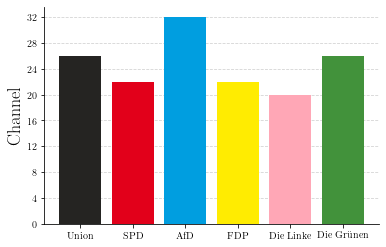

In [647]:
channel_count = corpus.groupby('party').nunique()['channelId']

fig = plot_bar(channel_count, 'Channel')
fig.savefig('outputs/yt-channel-count.pdf', bbox_inches = 'tight', pad_inches = 0)

In [648]:
print("Channel which uploaded videos in investigated periods:", corpus.channelId.nunique())
print("Number of faction-related channels:", sum(corpus.faction)/len(corpus))

Channel which uploaded videos in investigated periods: 148
Number of faction-related channels: 0.7142684984333575


## UPLOAD ANALYSIS
### General properties
#### Total videos

In [649]:
print("Total number of videos in both investigated periods:", len(corpus))
print("Total number of words contained in all videos:", corpus['subtitle'].apply(lambda x: len(x.split())).sum())

Total number of videos in both investigated periods: 8298
Total number of words contained in all videos: 9125283


#### Average videos per channel

In [650]:
corpus.reset_index().groupby(['channelId', 'party']).count()['videoId'].groupby('party').median()

party
afd      54.5
fdp      16.0
grüne    15.0
linke    21.0
spd      21.5
union    12.5
Name: videoId, dtype: float64

#### Missing subtitles count

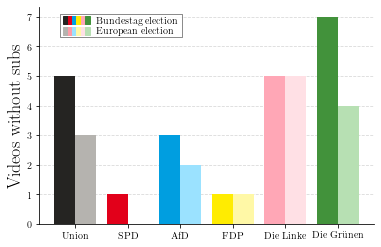

In [651]:
bt_msubtitle_count = bt_corpus.groupby('party')['subtitle'].apply(lambda df: sum(df.apply(lambda x: len(x) < 10)))
eu_msubtitle_count = eu_corpus.groupby('party')['subtitle'].apply(lambda df: sum(df.apply(lambda x: len(x) < 10)))
fig = plot_compare_bar(bt_msubtitle_count, eu_msubtitle_count, 'Videos without subs', legend_left=True)
fig.savefig('outputs/yt-videos-without-subs-count.pdf', bbox_inches = 'tight', pad_inches = 0)

### All videos

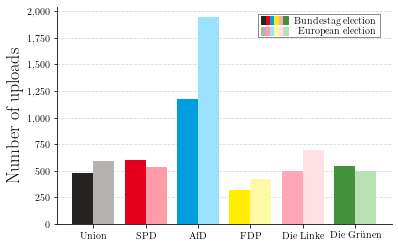

In [652]:
bt_video_count = bt_corpus.groupby('party')['title'].count()
eu_video_count = eu_corpus.groupby('party')['title'].count()

fig = plot_compare_bar(bt_video_count, eu_video_count, 'Number of uploads')
plt.savefig('outputs/yt-video-count.pdf', bbox_inches = 'tight', pad_inches = 0)

#### State level

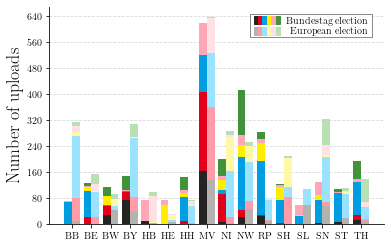

In [653]:
bt = bt_corpus.groupby(['party','state'])['title'].count().unstack().T.drop('DE')
eu = eu_corpus.groupby(['party','state'])['title'].count().unstack().T.drop('DE')

fig = plot_stacked_compare_bar(bt, eu, 'Number of uploads')
plt.savefig('outputs/yt-video-count-all.pdf', bbox_inches = 'tight', pad_inches = 0)

#### Faction-unrelated

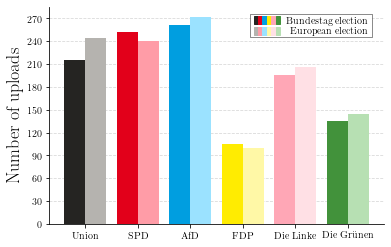

In [654]:
bt_video_count = bt_corpus[~bt_corpus.faction].groupby('party')['title'].count()
eu_video_count = eu_corpus[~eu_corpus.faction].groupby('party')['title'].count()

fig = plot_compare_bar(bt_video_count, eu_video_count, 'Number of uploads')
plt.savefig('outputs/yt-no-faction-video-count.pdf', bbox_inches = 'tight', pad_inches = 0)

#### Faction-related

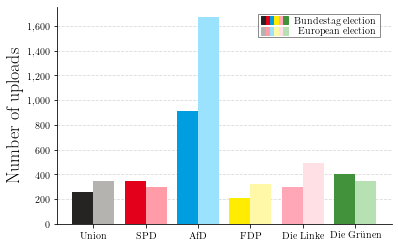

In [655]:
bt_video_count = bt_corpus[bt_corpus.faction].groupby('party')['title'].count()
eu_video_count = eu_corpus[eu_corpus.faction].groupby('party')['title'].count()

fig = plot_compare_bar(bt_video_count, eu_video_count, 'Number of uploads')
plt.savefig('outputs/yt-faction-video-count.pdf', bbox_inches = 'tight', pad_inches = 0)

### Federal-wide channels
#### Faction-unrelated

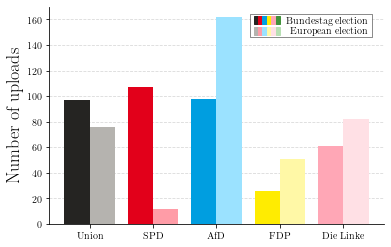

In [656]:
bt_video_count = bt_corpus[~bt_corpus.faction & (bt_corpus.state == 'DE')].groupby('party')['title'].count()
eu_video_count = eu_corpus[~eu_corpus.faction & (eu_corpus.state == 'DE')].groupby('party')['title'].count()

fig = plot_compare_bar(bt_video_count, eu_video_count, 'Number of uploads')
plt.savefig('outputs/yt-nfaction-video-count-federalwide.pdf', bbox_inches = 'tight', pad_inches = 0)

#### Faction-related

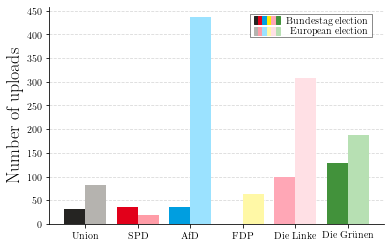

In [657]:
bt_video_count = bt_corpus[bt_corpus.faction & (bt_corpus.state == 'DE')].groupby('party')['title'].count()
eu_video_count = eu_corpus[eu_corpus.faction & (eu_corpus.state == 'DE')].groupby('party')['title'].count()

fig = plot_compare_bar(bt_video_count, eu_video_count, 'Number of uploads')
plt.savefig('outputs/yt-faction-video-count-federalwide.pdf', bbox_inches = 'tight', pad_inches = 0)

### Time analysis

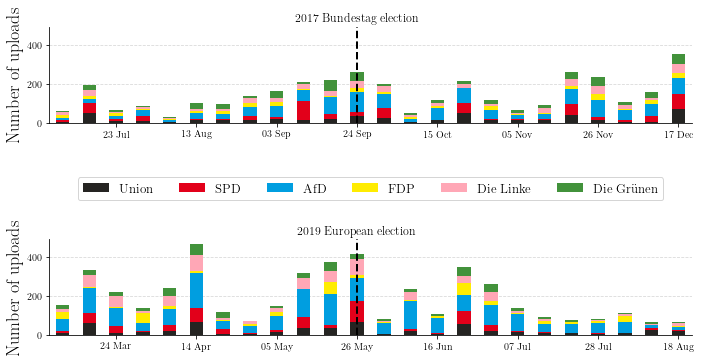

In [658]:
bt_upload_count = bt_corpus.groupby([pd.Grouper(key='publishedAt', freq='W', label='right'), 'party'])['title'].count().unstack()
eu_upload_count = eu_corpus.groupby([pd.Grouper(key='publishedAt', freq='W', label='right'), 'party'])['title'].count().unstack()
fig = plot_hist(bt_upload_count, eu_upload_count, 'Number of uploads')
fig.savefig('outputs/yt-upload-count-analysis.pdf', bbox_inches = 'tight', pad_inches = 0)

#### Faction-unrelated

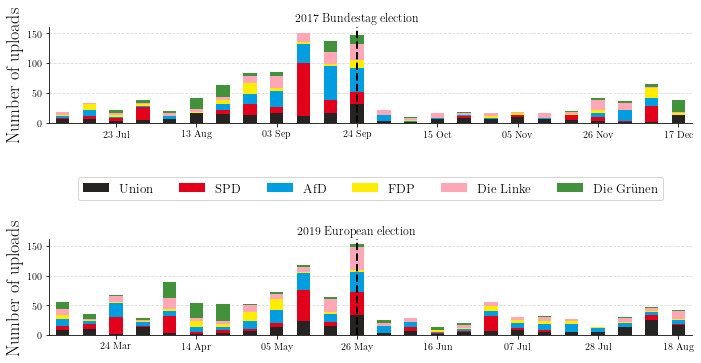

In [659]:
bt_nfaction_upload_count = bt_corpus[~bt_corpus.faction].groupby([pd.Grouper(key='publishedAt', freq='W', label='right'), 'party'])['title'].count().unstack()
eu_nfaction_upload_count = eu_corpus[~eu_corpus.faction].groupby([pd.Grouper(key='publishedAt', freq='W', label='right'), 'party'])['title'].count().unstack()
fig = plot_hist(bt_nfaction_upload_count, eu_nfaction_upload_count, 'Number of uploads')
fig.savefig('outputs/yt-nfaction-upload-count-analysis.pdf', bbox_inches = 'tight', pad_inches = 0)

#### Faction-related

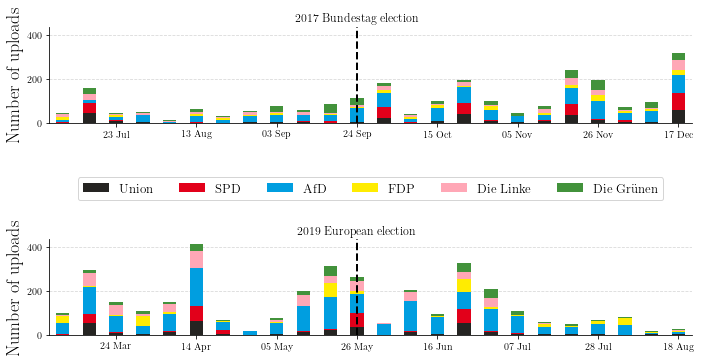

In [660]:
bt_faction_upload_count = bt_corpus[bt_corpus.faction].groupby([pd.Grouper(key='publishedAt', freq='W', label='right'), 'party'])['title'].count().unstack()
eu_faction_upload_count = eu_corpus[eu_corpus.faction].groupby([pd.Grouper(key='publishedAt', freq='W', label='right'), 'party'])['title'].count().unstack()
fig = plot_hist(bt_faction_upload_count, eu_faction_upload_count, 'Number of uploads')
fig.savefig('outputs/yt-faction-upload-count-analysis.pdf', bbox_inches = 'tight', pad_inches = 0)

## VIDEO DURATION ANALYSIS

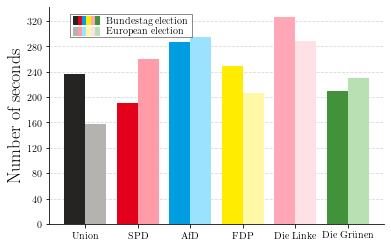

In [661]:
bt_video_length = bt_corpus.groupby('party')['duration'].median()
eu_video_length = eu_corpus.groupby('party')['duration'].median()

fig = plot_compare_bar(bt_video_length, eu_video_length, 'Number of seconds', legend_left=True)
plt.savefig('outputs/yt-duration-median.pdf', bbox_inches = 'tight', pad_inches = 0)

## VIEW ANALYSIS
### General properties

#### Average views per channel

In [662]:
corpus.reset_index().groupby(['channelId', 'party']).sum()['viewCount'].groupby('party').median()

party
afd      70576.0
fdp       2700.0
grüne     2157.5
linke     3863.5
spd       2982.0
union     1435.0
Name: viewCount, dtype: float64

#### Average views per video

In [663]:
corpus.reset_index().groupby(['party'])['viewCount'].mean()

party
afd      5319.034947
fdp      1925.013459
grüne    7072.864865
linke    1026.605858
spd      1773.865198
union    3969.973832
Name: viewCount, dtype: float64

#### Federal-wide channels vs state-level channels

In [664]:
corpus.groupby(['party', corpus.state == 'DE'])['viewCount'].sum()/(corpus.groupby('party')['viewCount'].sum())

party  state
afd    False    0.324430
       True     0.675570
fdp    False    0.092572
       True     0.907428
grüne  False    0.039397
       True     0.960603
linke  False    0.082253
       True     0.917747
spd    False    0.189288
       True     0.810712
union  False    0.126171
       True     0.873829
Name: viewCount, dtype: float64

In [665]:
corpus.groupby(corpus.state == 'DE')['viewCount'].sum()/(corpus['viewCount'].sum())

state
False    0.207741
True     0.792259
Name: viewCount, dtype: float64

### All videos

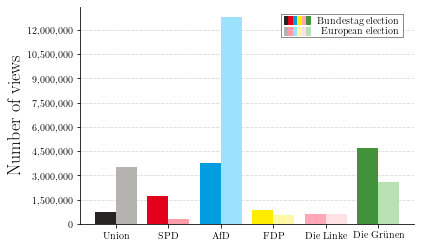

In [666]:
bt_view_count = bt_corpus.groupby('party')['viewCount'].sum()
eu_view_count = eu_corpus.groupby('party')['viewCount'].sum()

fig = plot_compare_bar(bt_view_count, eu_view_count, 'Number of views')
plt.savefig('outputs/yt-view-count.pdf', bbox_inches = 'tight', pad_inches = 0)

#### State level

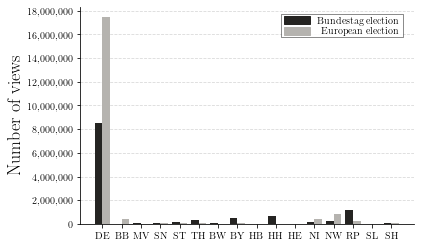

In [667]:
bt_view_count_all = bt_corpus.groupby('state')['viewCount'].sum()
eu_view_count_all = eu_corpus.groupby('state')['viewCount'].sum()

fig = plot_compare_bar(bt_view_count_all, eu_view_count_all, 'Number of views', 
                       color='union',
                       index_label_dic=states)
plt.savefig('outputs/yt-view-count-all.pdf', bbox_inches = 'tight', pad_inches = 0)

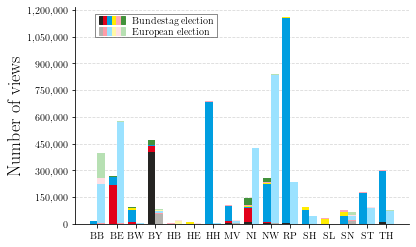

In [668]:
bt = bt_corpus.groupby(['party','state'])['viewCount'].sum().unstack().T.drop('DE')
eu = eu_corpus.groupby(['party','state'])['viewCount'].sum().unstack().T.drop('DE')
fig = plot_stacked_compare_bar(bt, eu, "Number of views", legend_left=True)
plt.savefig('outputs/yt-view-count-stacked.pdf', bbox_inches = 'tight', pad_inches = 0)

#### Compare old states / new states

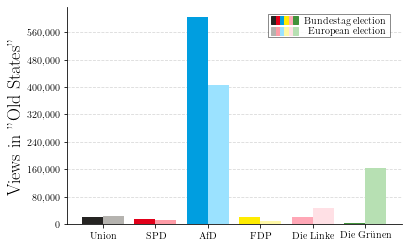

In [669]:
data.loc[:, 'is_old_state_video'] = data['state'].apply(lambda x: x in old_states)
bt = data[bt_period & (corpus.state != 'DE') & (corpus.state != 'BE')].groupby(['party', 'is_old_state_video'])['viewCount'].sum().unstack()
eu = data[eu_period & (corpus.state != 'DE') & (corpus.state != 'BE')].groupby(['party', 'is_old_state_video'])['viewCount'].sum().unstack()

fig = plot_compare_bar(bt[False], eu[False], 'Views in "Old States"')

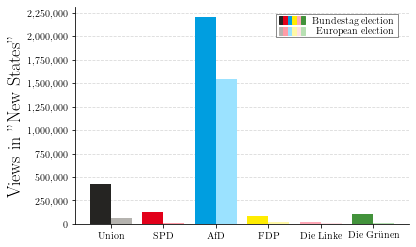

In [670]:
fig = plot_compare_bar(bt[True], eu[True], 'Views in "New States"')

In [671]:
temp = corpus.copy()
temp.loc[:, 'is_old_state_video'] = corpus['state'].apply(lambda x: x in old_states)
temp['viewCount'] = temp['viewCount'].fillna(0)
total_views = temp[(temp.state != 'DE') & (temp.state != 'BE')].groupby('party')['viewCount'].sum()
region_views = temp[(temp.state != 'DE') & (temp.state != 'BE')].groupby(['party', 'is_old_state_video'])['viewCount'].sum().unstack()

print(region_views[True]/total_views)
print(region_views[False]/total_views)
#fig = plot_compare_bar(eu[False], eu[True], 'Views in "Old States"')

party
afd      0.788071
fdp      0.797200
grüne    0.408657
linke    0.345436
spd      0.830745
union    0.919392
dtype: float64
party
afd      0.211929
fdp      0.202800
grüne    0.591343
linke    0.654564
spd      0.169255
union    0.080608
dtype: float64


#### Faction-unrelated

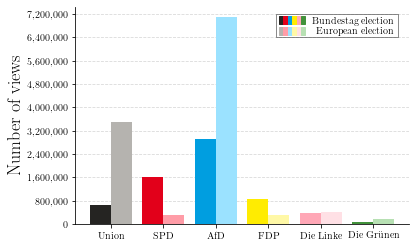

In [672]:
bt_view_count = bt_corpus[~bt_corpus.faction].groupby('party')['viewCount'].sum()
eu_view_count = eu_corpus[~eu_corpus.faction].groupby('party')['viewCount'].sum()

fig = plot_compare_bar(bt_view_count, eu_view_count, 'Number of views')
plt.savefig('outputs/yt-view-count-nfaction.pdf', bbox_inches = 'tight', pad_inches = 0)

#### Faction-related

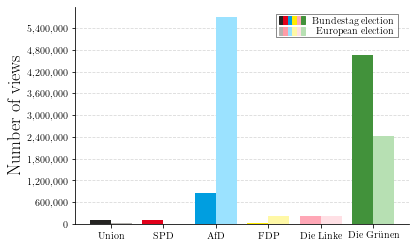

In [673]:
bt_view_count = bt_corpus[bt_corpus.faction].groupby('party')['viewCount'].sum()
eu_view_count = eu_corpus[eu_corpus.faction].groupby('party')['viewCount'].sum()

fig = plot_compare_bar(bt_view_count, eu_view_count, 'Number of views')
plt.savefig('outputs/yt-view-count-faction.pdf', bbox_inches = 'tight', pad_inches = 0)

### Federal-wide channels

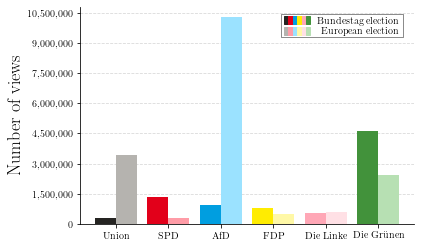

In [674]:
bt_view_count = bt_corpus[bt_corpus.state == 'DE'].groupby('party')['viewCount'].sum()
eu_view_count = eu_corpus[eu_corpus.state == 'DE'].groupby('party')['viewCount'].sum()

fig = plot_compare_bar(bt_view_count, eu_view_count, 'Number of views')
plt.savefig('outputs/yt-view-count-de.pdf', bbox_inches = 'tight', pad_inches = 0)

#### Faction-unrelated

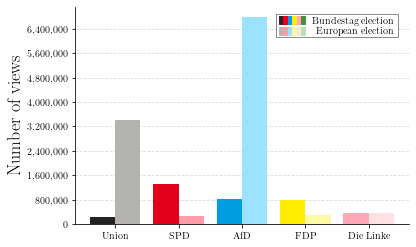

In [675]:
bt = bt_corpus[~bt_corpus.faction & (bt_corpus.state == 'DE')].groupby('party')['viewCount'].sum()
eu = eu_corpus[~eu_corpus.faction & (eu_corpus.state == 'DE')].groupby('party')['viewCount'].sum()

fig = plot_compare_bar(bt, eu, 'Number of views')
plt.savefig('outputs/yt-view-count-de-nfaction.pdf', bbox_inches = 'tight', pad_inches = 0)

#### Faction-related

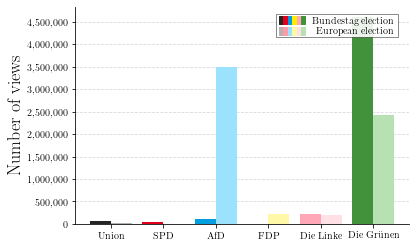

In [676]:
bt = bt_corpus[bt_corpus.faction & (bt_corpus.state == 'DE')].groupby('party')['viewCount'].sum()
eu = eu_corpus[eu_corpus.faction & (eu_corpus.state == 'DE')].groupby('party')['viewCount'].sum()

fig = plot_compare_bar(bt, eu, 'Number of views')
plt.savefig('outputs/yt-view-count-de-faction.pdf', bbox_inches = 'tight', pad_inches = 0)

### Time analysis
#### All videos

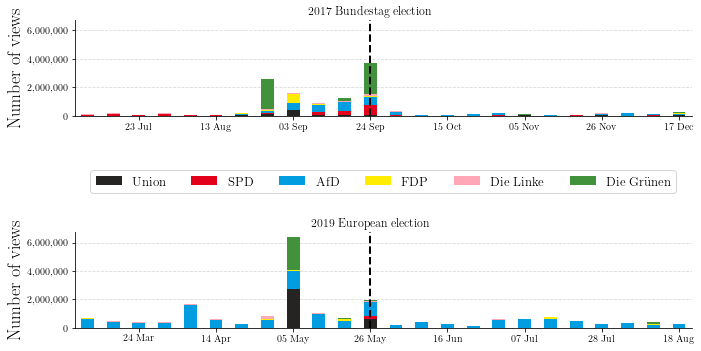

In [677]:
bt_view_count = bt_corpus.groupby([pd.Grouper(key='publishedAt', freq='W', label='right'), 'party'])['viewCount'].sum().unstack()
eu_view_count = eu_corpus.groupby([pd.Grouper(key='publishedAt', freq='W', label='right'), 'party'])['viewCount'].sum().unstack()
fig = plot_hist(bt_view_count, eu_view_count, 'Number of views')
fig.savefig('outputs/yt-view-count-analysis.pdf', bbox_inches = 'tight', pad_inches = 0)

#### Faction-unrelated

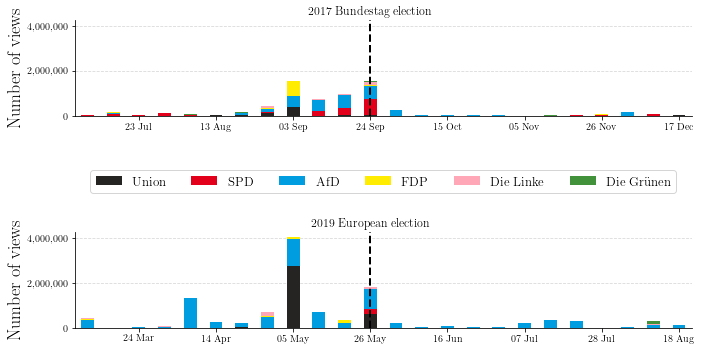

In [678]:
bt_nfaction_view_count = bt_corpus[~bt_corpus.faction].groupby([pd.Grouper(key='publishedAt', freq='W', label='right'), 'party'])['viewCount'].sum().unstack()
eu_nfaction_view_count = eu_corpus[~eu_corpus.faction].groupby([pd.Grouper(key='publishedAt', freq='W', label='right'), 'party'])['viewCount'].sum().unstack()
fig = plot_hist(bt_nfaction_view_count, eu_nfaction_view_count, 'Number of views')
fig.savefig('outputs/yt-no-faction-view-count-analysis.pdf', bbox_inches = 'tight', pad_inches = 0)

#### Faction-related

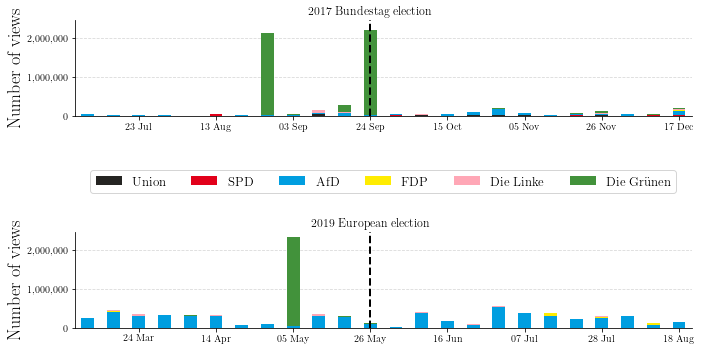

In [679]:
bt_faction_view_count = bt_corpus[bt_corpus.faction].groupby([pd.Grouper(key='publishedAt', freq='W', label='right'), 'party'])['viewCount'].sum().unstack()
eu_faction_view_count = eu_corpus[eu_corpus.faction].groupby([pd.Grouper(key='publishedAt', freq='W', label='right'), 'party'])['viewCount'].sum().unstack()
fig = plot_hist(bt_faction_view_count, eu_faction_view_count, 'Number of views')
fig.savefig('outputs/yt-faction-view-count-analysis.pdf', bbox_inches = 'tight', pad_inches = 0)

## COMMENT ANALYSIS

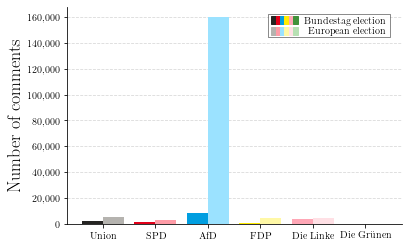

In [680]:
bt_comment_count = bt_corpus.groupby('party')['commentCount'].sum()
eu_comment_count = eu_corpus.groupby('party')['commentCount'].sum()

fig = plot_compare_bar(bt_comment_count, eu_comment_count, 'Number of comments')
plt.savefig('outputs/yt-comment-count.pdf', bbox_inches = 'tight', pad_inches = 0)

In [681]:
bt_disabled_comments = bt_corpus[bt_corpus.state == 'DE'].groupby('party')['commentCount'].apply(lambda l: sum(np.isnan(x) for x in l)/len(l))
eu_disabled_comments = eu_corpus[eu_corpus.state == 'DE'].groupby('party')['commentCount'].apply(lambda l: sum(np.isnan(x) for x in l)/len(l))
print("BT: " + str([(party, bt_disabled_comments[party]/len(bt_corpus.query('party == @party'))) for party in parties]))
print("EU: " + str([(party, eu_disabled_comments[party]/len(eu_corpus.query('party == @party'))) for party in parties]))
disabled_comments = corpus[corpus.state == 'DE'].groupby('party')['commentCount'].apply(lambda l: sum(np.isnan(x) for x in l)/len(l))
disabled_comments

#fig = plot_compare_bar(bt_disabled_comments, eu_disabled_comments, 'Percentage of\nClosed Comment Sections', legend_left=True)
#plt.savefig('outputs/yt-disabled_comments.pdf', bbox_inches = 'tight', pad_inches = 0)

BT: [('union', 0.0005037947117806705), ('spd', 0.0), ('afd', 0.0006281688876923767), ('fdp', 0.0030237058538945334), ('linke', 0.0), ('grüne', 0.0015905085328633453)]
EU: [('union', 0.0008111511943134032), ('spd', 0.0), ('afd', 0.0), ('fdp', 0.0), ('linke', 0.0), ('grüne', 0.0020094562647754136)]


party
afd      0.133880
fdp      0.177305
grüne    0.940063
linke    0.000000
spd      0.000000
union    0.372822
Name: commentCount, dtype: float64

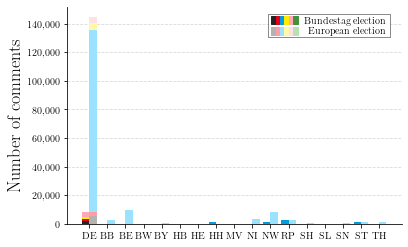

In [682]:
bt = bt_corpus.groupby(['party', 'state'])['commentCount'].sum().unstack().T
eu = eu_corpus.groupby(['party', 'state'])['commentCount'].sum().unstack().T
bt = bt.loc[['DE'] + [ix for ix in bt.index if ix != 'DE']]
eu = eu.loc[['DE'] + [ix for ix in eu.index if ix != 'DE']]

fig = plot_stacked_compare_bar(bt, eu, 'Number of comments') 
plt.savefig('outputs/yt-comment-count-states.pdf', bbox_inches = 'tight', pad_inches = 0)

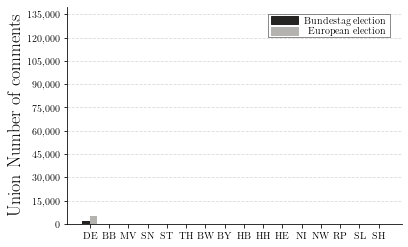

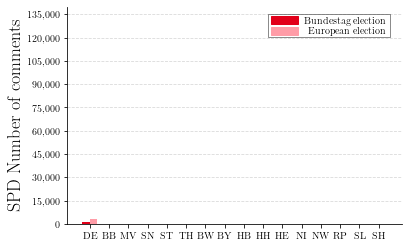

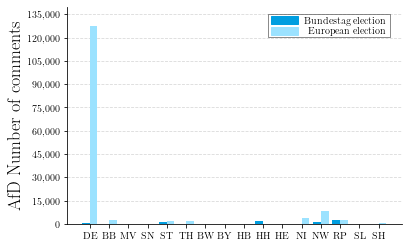

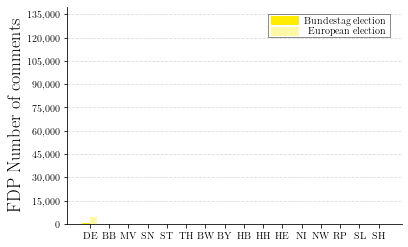

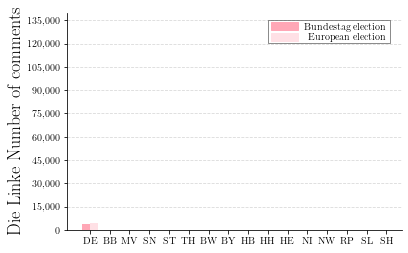

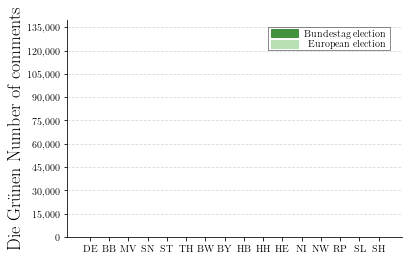

In [683]:
for party in parties:
    bt = bt_corpus.loc[bt_corpus.party == party].groupby('state')['commentCount'].sum()
    eu = eu_corpus.loc[eu_corpus.party == party].groupby('state')['commentCount'].sum()

    fig = plot_compare_bar(bt, eu, parties[party] + ' Number of comments', 
                           color=party,
                           index_label_dic=states,
                           max_y=140000)
    plt.savefig('outputs/yt-comment-count-' + party + '.pdf', bbox_inches = 'tight', pad_inches = 0)

#### All comments in time

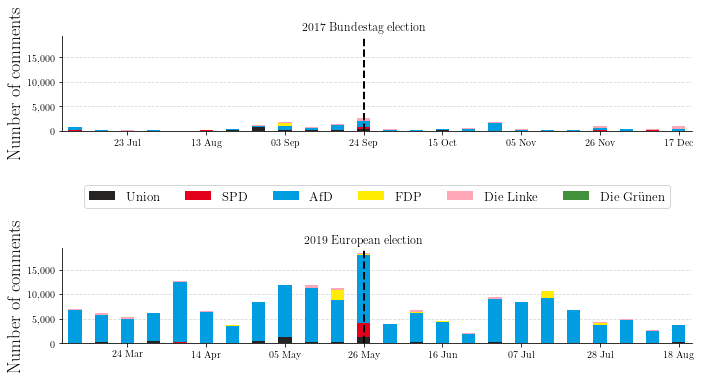

In [684]:
bt_comment_count = bt_corpus.groupby([pd.Grouper(key='publishedAt', freq='W', label='right'), 'party'])['commentCount'].sum().unstack()
eu_comment_count = eu_corpus.groupby([pd.Grouper(key='publishedAt', freq='W', label='right'), 'party'])['commentCount'].sum().unstack()
fig = plot_hist(bt_comment_count, eu_comment_count, 'Number of comments')
fig.savefig('outputs/yt-comment-count-analysis.pdf', bbox_inches = 'tight', pad_inches = 0)

#### Federal-wide videos in time

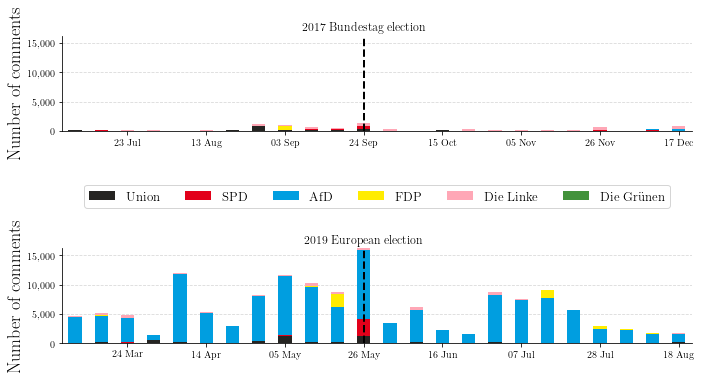

In [685]:
bt_comment_count = bt_corpus[bt_corpus.state == 'DE'].groupby([pd.Grouper(key='publishedAt', freq='W', label='right'), 'party'])['commentCount'].sum().unstack()
eu_comment_count = eu_corpus[eu_corpus.state == 'DE'].groupby([pd.Grouper(key='publishedAt', freq='W', label='right'), 'party'])['commentCount'].sum().unstack()
fig = plot_hist(bt_comment_count, eu_comment_count, 'Number of comments')
fig.savefig('outputs/yt-comment-count-analysis-de.pdf', bbox_inches = 'tight', pad_inches = 0)

#### Non-faction videos

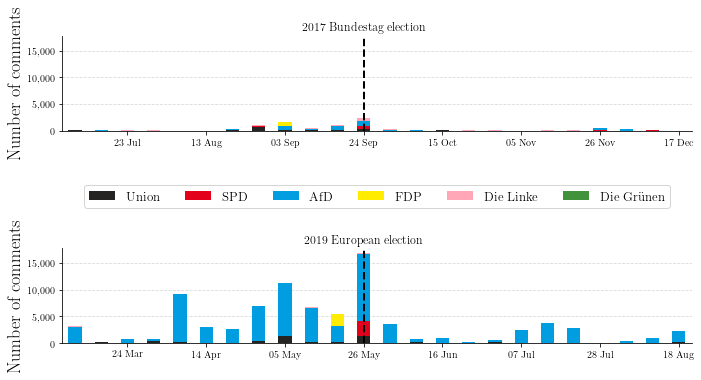

In [686]:
bt_nfaction_comment_count = bt_corpus[~bt_corpus.faction].groupby([pd.Grouper(key='publishedAt', freq='W', label='right'), 'party'])['commentCount'].sum().unstack()
eu_nfaction_comment_count = eu_corpus[~eu_corpus.faction].groupby([pd.Grouper(key='publishedAt', freq='W', label='right'), 'party'])['commentCount'].sum().unstack()
fig = plot_hist(bt_nfaction_comment_count, eu_nfaction_comment_count, 'Number of comments')
fig.savefig('outputs/yt-no-faction-comment-count-analysis.pdf', bbox_inches = 'tight', pad_inches = 0)

#### Faction-only videos

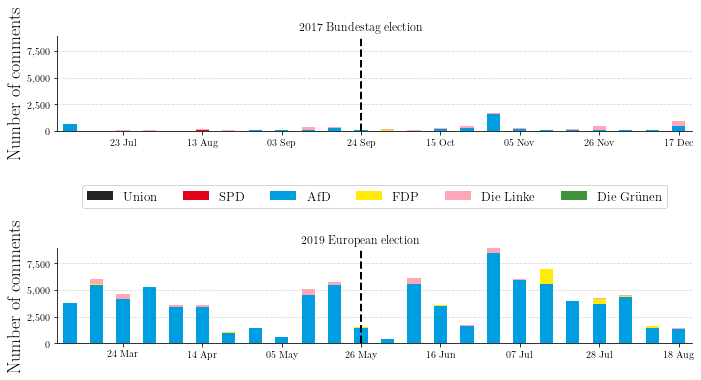

In [687]:
bt_faction_comment_count = bt_corpus[bt_corpus.faction].groupby([pd.Grouper(key='publishedAt', freq='W', label='right'), 'party'])['commentCount'].sum().unstack()
eu_faction_comment_count = eu_corpus[eu_corpus.faction].groupby([pd.Grouper(key='publishedAt', freq='W', label='right'), 'party'])['commentCount'].sum().unstack()
fig = plot_hist(bt_faction_comment_count, eu_faction_comment_count, 'Number of comments')
fig.savefig('outputs/yt-faction-comment-analysis.pdf', bbox_inches = 'tight', pad_inches = 0)

In [688]:
bt_corpus.reset_index().groupby(['channelId', 'party']).sum()['commentCount'].groupby('party').mean()

party
afd      324.760000
fdp       51.875000
grüne      9.000000
linke    225.666667
spd       86.166667
union    108.950000
Name: commentCount, dtype: float64

In [689]:
eu_corpus.reset_index().groupby(['channelId', 'party']).sum()['commentCount'].groupby('party').mean()

party
afd      5930.333333
fdp       289.062500
grüne       7.130435
linke     248.888889
spd       146.238095
union     221.083333
Name: commentCount, dtype: float64

In [690]:
bt_corpus[bt_corpus.state == 'DE'].reset_index().groupby(['channelId', 'party']).sum()['commentCount'].groupby('party').mean()

party
afd       171.5
fdp       757.0
grüne     100.0
linke    1973.5
spd       639.0
union    1062.5
Name: commentCount, dtype: float64

In [691]:
eu_corpus[eu_corpus.state == 'DE'].reset_index().groupby(['channelId', 'party']).sum()['commentCount'].groupby('party').mean()

party
afd      42497.333333
fdp       2277.000000
grüne       23.000000
linke     2185.000000
spd       1487.000000
union     2615.500000
Name: commentCount, dtype: float64

## RATING ANALYSIS

In [692]:
print(bt_corpus[['likeCount', 'dislikeCount']].sum())
print(eu_corpus[['likeCount', 'dislikeCount']].sum())

likeCount       103061.0
dislikeCount     88281.0
dtype: float64
likeCount       1001289.0
dislikeCount      90216.0
dtype: float64


#### All videos

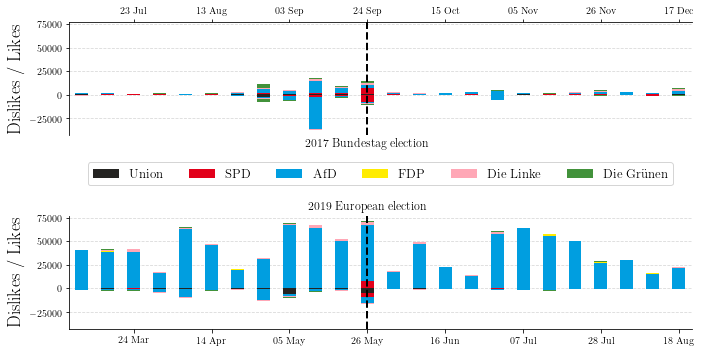

In [693]:
bt_like_count = bt_corpus.groupby([pd.Grouper(key='publishedAt', freq='W', label='right'), 'party'])['likeCount'].sum().unstack()
eu_like_count = eu_corpus.groupby([pd.Grouper(key='publishedAt', freq='W', label='right'), 'party'])['likeCount'].sum().unstack()
bt_dislike_count = bt_corpus.groupby([pd.Grouper(key='publishedAt', freq='W', label='right'), 'party'])['dislikeCount'].sum().unstack()
eu_dislike_count = eu_corpus.groupby([pd.Grouper(key='publishedAt', freq='W', label='right'), 'party'])['dislikeCount'].sum().unstack()
fig = plot_negative_hist(bt_like_count, bt_dislike_count, eu_like_count, eu_dislike_count, 'Dislikes / Likes')
fig.savefig('outputs/yt-rating-analysis.pdf', bbox_inches = 'tight', pad_inches = 0)

#### Non-faction videos

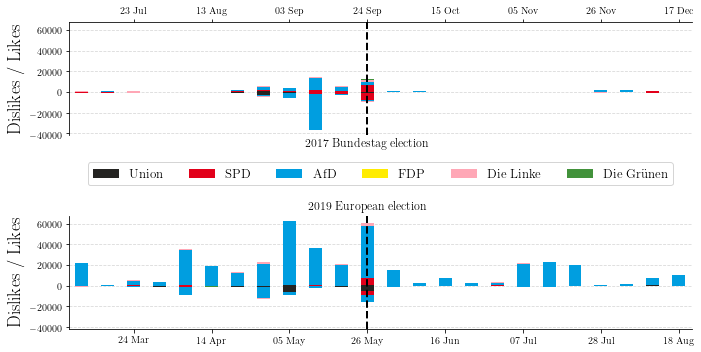

In [694]:
bt_nfaction_like_count = bt_corpus[~bt_corpus.faction].groupby([pd.Grouper(key='publishedAt', freq='W', label='right'), 'party'])['likeCount'].sum().unstack()
eu_nfaction_like_count = eu_corpus[~eu_corpus.faction].groupby([pd.Grouper(key='publishedAt', freq='W', label='right'), 'party'])['likeCount'].sum().unstack()
bt_nfaction_dislike_count = bt_corpus[~bt_corpus.faction].groupby([pd.Grouper(key='publishedAt', freq='W', label='right'), 'party'])['dislikeCount'].sum().unstack()
eu_nfaction_dislike_count = eu_corpus[~eu_corpus.faction].groupby([pd.Grouper(key='publishedAt', freq='W', label='right'), 'party'])['dislikeCount'].sum().unstack()
fig = plot_negative_hist(bt_nfaction_like_count, bt_nfaction_dislike_count, eu_nfaction_like_count, eu_nfaction_dislike_count, 'Dislikes / Likes')
fig.savefig('outputs/yt-rating-analysis-nfaction.pdf', bbox_inches = 'tight', pad_inches = 0)

#### Faction-only videos

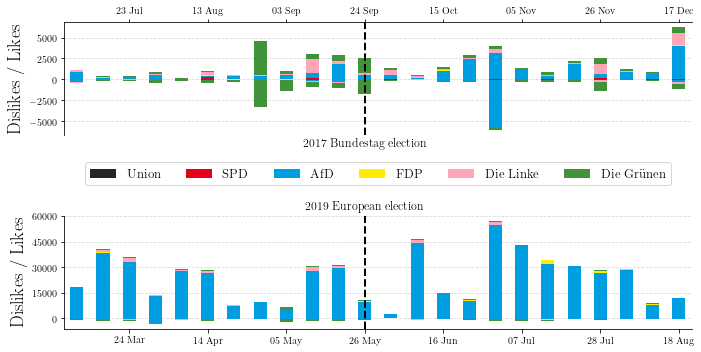

In [695]:
bt_faction_like_count = bt_corpus[bt_corpus.faction].groupby([pd.Grouper(key='publishedAt', freq='W', label='right'), 'party'])['likeCount'].sum().unstack()
eu_faction_like_count = eu_corpus[eu_corpus.faction].groupby([pd.Grouper(key='publishedAt', freq='W', label='right'), 'party'])['likeCount'].sum().unstack()
bt_faction_dislike_count = bt_corpus[bt_corpus.faction].groupby([pd.Grouper(key='publishedAt', freq='W', label='right'), 'party'])['dislikeCount'].sum().unstack()
eu_faction_dislike_count = eu_corpus[eu_corpus.faction].groupby([pd.Grouper(key='publishedAt', freq='W', label='right'), 'party'])['dislikeCount'].sum().unstack()
fig = plot_negative_hist(bt_faction_like_count, bt_faction_dislike_count, eu_faction_like_count, eu_faction_dislike_count, 'Dislikes / Likes', sharey=False)
fig.savefig('outputs/yt-rating-analysis-faction.pdf', bbox_inches = 'tight', pad_inches = 0)

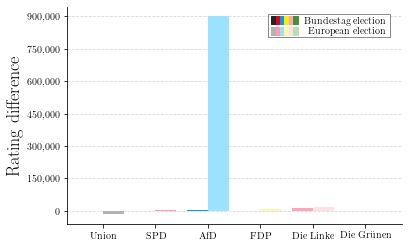

In [696]:
data['ratingDifference'] = (data['likeCount'] - data['dislikeCount'])
 
bt_rating_count = data[bt_period].groupby('party')['ratingDifference'].sum()
eu_rating_count = data[eu_period].groupby('party')['ratingDifference'].sum()

fig = plot_compare_bar(bt_rating_count, eu_rating_count, 'Rating difference')
plt.savefig('outputs/yt-rating-difference.pdf', bbox_inches = 'tight', pad_inches = 0)

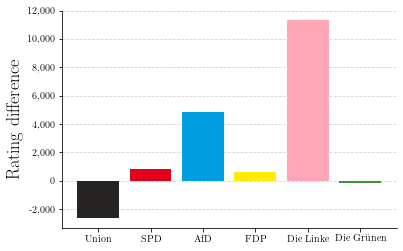

In [697]:
fig = plot_bar(bt_rating_count, 'Rating difference')
fig.savefig('outputs/yt-rating-difference_bt.pdf', bbox_inches = 'tight', pad_inches = 0)

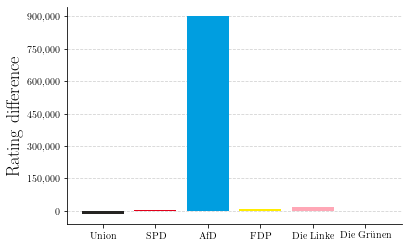

In [698]:
fig = plot_bar(eu_rating_count, 'Rating difference')
fig.savefig('outputs/yt-rating-difference_eu.pdf', bbox_inches = 'tight', pad_inches = 0)

## CommentCount

In [699]:
data['publishedAt'] = pd.to_datetime(data['publishedAt']) 

In [700]:
viewCount = data.groupby([data["publishedAt"].dt.month, data['party']]).sum()['viewCount'].unstack()
viewCount

party,afd,fdp,grüne,linke,spd,union
publishedAt,,,,,,
1,1488221,36852,9982,106532,2213,18610
2,2011746,29500,46789,169407,132779,47241
3,2204570,66275,193252,349433,182467,114133
4,3476892,640326,1357117,412128,132825,2864859
5,4990056,174919,1584432,228428,367709,708796
6,1662777,26570,156896,419681,620312,78526
7,2348206,182948,21032,85910,229349,35549
8,1960102,794912,2313198,167043,106961,538009
9,2244231,55916,2447074,292858,1263107,106931


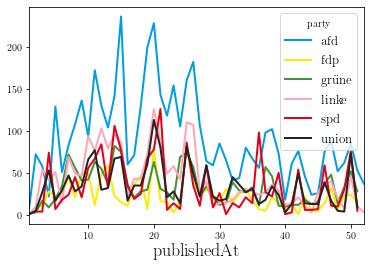

In [428]:
count = data.groupby([data["publishedAt"].dt.week, data['party']])['title'].count().unstack()
count.plot(color=count.apply(lambda x: colors[x.name]))

In [429]:
count.sum()

party
afd      4735.0
fdp      1193.0
grüne    1709.0
linke    2206.0
spd      1746.0
union    1734.0
dtype: float64

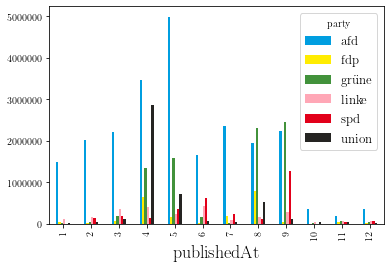

In [430]:
viewCount.plot(kind='bar', color=viewCount.apply(lambda x: colors[x.name]))

In [431]:
data.columns

Index(['caption', 'categoryId', 'channelId', 'channelTitle', 'commentCount',
       'contentRating', 'defaultAudioLanguage', 'defaultLanguage',
       'definition', 'description', 'dimension', 'dislikeCount', 'duration',
       'faction', 'favoriteCount', 'licensedContent', 'likeCount',
       'liveBroadcastContent', 'localized', 'neu', 'party', 'projection',
       'publishedAt', 'regionRestriction', 'state', 'subtitle', 'tags',
       'thumbnails', 'title', 'updated', 'viewCount', 'is_old_state_video',
       'ratingDifference'],
      dtype='object')

## Tags

In [432]:
from itertools import chain
from collections import Counter

tags_by_party = {party: [tag.lower() for tag in chain(*data.loc[data['party'] == party, 'tags'])] for party in parties}
most_used_tags_by_party = {party: Counter(tags_by_party[party]) for party in parties}
most_used_tags_by_party = pd.DataFrame.from_dict(most_used_tags_by_party).fillna(0).astype(int)

In [151]:
display_side_by_side(*(top_n(most_used_tags_by_party, party, 15) for party in parties))

,union
cdu,417
csu,169
politik,161
union,137
angela merkel,136
cdu-landtagsfraktion,126
baden-württemberg,119
annegret kramp-karrenbauer,110
cdu/csu,101
cdu deutschlands,100
